The question addressed here is, if we are using ReadUntil and human genomic DNA with no amplification, can we achieve reasonable coverage of the HLA region.

In [120]:
human_genome_size = 3e9
hla_size = 3.6e6                   # classical MHC is 3.6Mb
readuntil_thresh = 250             # events until readuntil kicks in, which is ~= bases
max_num_pores = 512                # only pores, i am not modeling channels since remuxing happens after 24hr
read_bases_per_second = 250        # R9
num_active_pores = 350             # empirical, out of 512
p_dna_in_pore = 0.01               # empirical, no idea what this should be
p_pore_blocked = 0.001             # empirical, after a read goes through, it might get blocked

In [121]:
p_hla = hla_size / human_genome_size
def is_hla():
    return np.random.random() < p_hla
print("Fraction of reads that will overlap HLA: {:.3g}".format(p_hla))

Fraction of reads that will overlap HLA: 0.0012


In [283]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from heapq import heappop, heappush

%matplotlib inline
%load_ext line_profiler
%config InlineBackend.figure_format = 'retina'

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


DNA fragment lengths
--------------------
In this simulation, readlength is identical to the lengths of DNA in solution (i.e., each DNA fragment is read in its entirety)

mean readlength: 12474, std: 13802


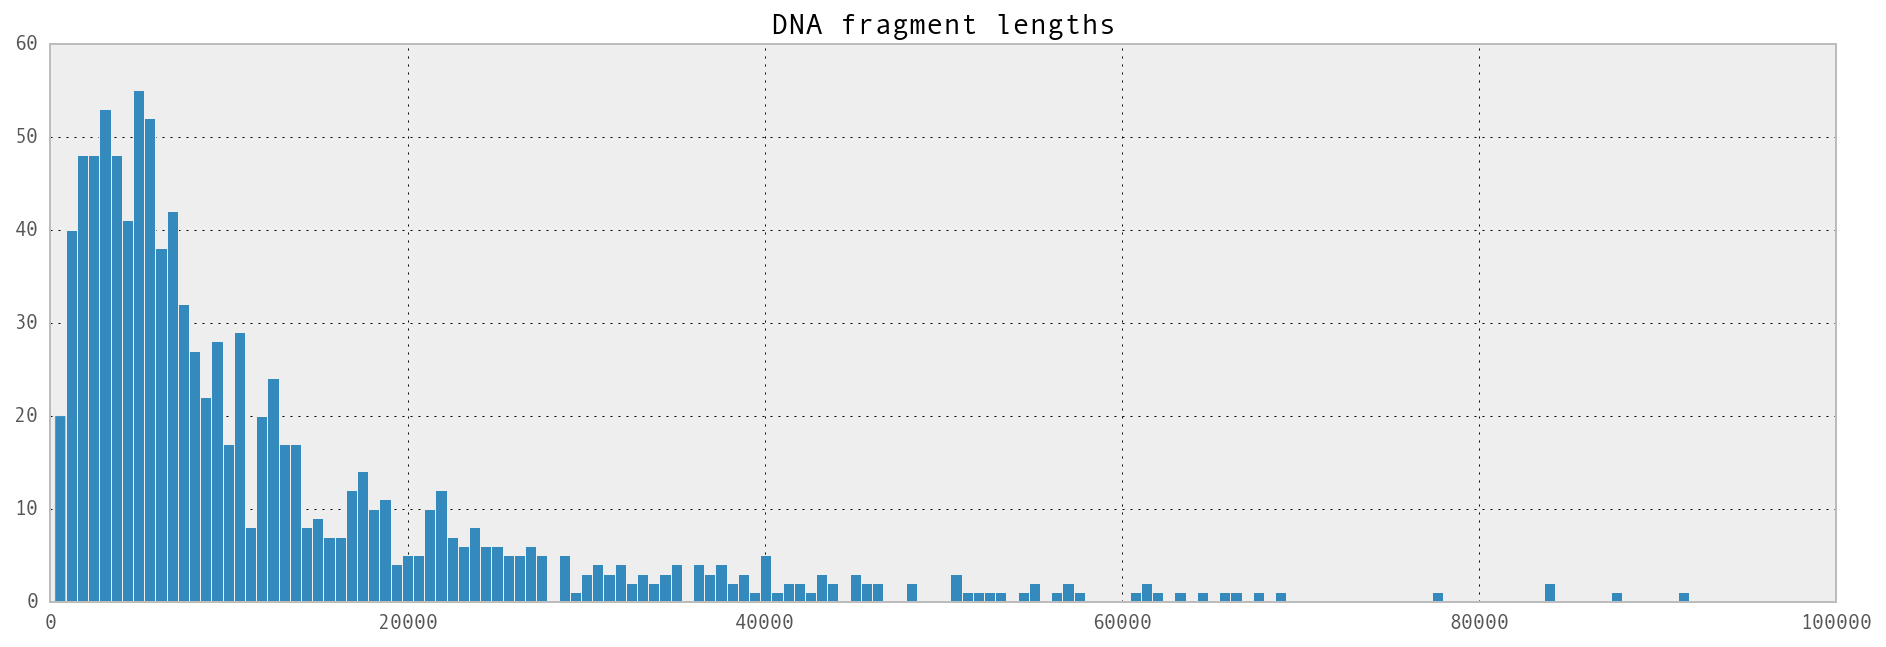

In [216]:
dna_lens = np.random.lognormal(9,1,1000).astype(np.int)
print("mean readlength: {:d}, std: {:d}".format(int(dna_lens.mean()), int(dna_lens.std())))

fig, ax = plt.subplots(1, 1, figsize=(16,5))
ax.set_xlim(0,100000)
ax.set_title("DNA fragment lengths")
_ = ax.hist(dna_lens, bins=200)

Simulation
--------------
Simulate events using a priority queue.

In [295]:
def time_to_load_dna_gen():
    N = 10000
    times = np.random.lognormal(3,1,size=N)
    print("Avg time to load DNA:\t{:.1f}s".format( np.mean(times) ))
    assert np.all(times>0), "lognormal should not return values <=0"
    yield from (times[i%N] for i in count())   
time_to_load_dna = time_to_load_dna_gen()

def new_dna_len_gen():
    N = 10000
    dna_lens = np.random.lognormal(9,1,size=N).astype(np.int)
    print("Avg DNA fragment length:\t{:.0f}".format( np.mean(dna_lens) ))
    assert np.all(dna_lens>0), "lognormal should not return values <=0"
    yield from (dna_lens[i%N] for i in count())
new_dna_len = new_dna_len_gen()

def time_to_read_dna(dna_len):
    return dna_len / read_bases_per_second

def is_blocked():
    return np.random.random() < p_pore_blocked

Event = namedtuple("event", ['time', 'pore', 'type', 'dna_len'])
class Task(object): # do not use Enum since it is unordered so breaks heap
    NOTHING, FOUND_DNA, DO_READUNTIL, END_READ = range(4)

def run_sim(run_hours, READUNTIL_HLA=True):
    queue = []
    def enqueue(this_time, prev_time, pore, etype, dna_len):
        heappush(queue, Event(this_time + prev_time, pore, etype, dna_len))
    
    run_time_sec = run_hours * 60 * 60    
    total_reads = []
    total_hla_reads = []
    total_pores_blocked = 0
    
    for i in range(num_active_pores):
        enqueue(next(time_to_load_dna), 0, i, Task.FOUND_DNA, None)
    
    while True:
        if len(queue) == 0:
            logging.warning("Empty queue (no active pores remain!)")
            break
        
        is_end_of_read = False
        event = heappop(queue)

        if event.time > run_time_sec:
            # cleanup()?
            break
        
        if event.type == Task.FOUND_DNA:
            dna_len = next(new_dna_len)
            if READUNTIL_HLA:
                enqueue(time_to_read_dna(readuntil_thresh), event.time, event.pore, Task.DO_READUNTIL, dna_len)
            else:
                enqueue(time_to_read_dna(dna_len), event.time, event.pore, Task.END_READ, dna_len)
        elif event.type == Task.DO_READUNTIL:
            if is_hla():
                enqueue(time_to_read_dna(max(0,event.dna_len-readuntil_thresh)), event.time, event.pore, Task.END_READ, event.dna_len)
            else:
                total_reads.append(readuntil_thresh)
                is_end_of_read = True
        elif event.type == Task.END_READ:
            total_reads.append(event.dna_len)
            total_hla_reads.append(event.dna_len)
            is_end_of_read = True
        else:
            raise ValueError("unknown Task")
    
        if is_end_of_read:
            if not is_blocked():
                enqueue(next(time_to_load_dna), event.time, event.pore, Task.FOUND_DNA, None)
            else:
                total_pores_blocked += 1
    
    print("\n[{:.1f} hour expt{}]".format(run_hours, " (HLA)" if READUNTIL_HLA else ""))
    print("Total DNA read:\t\t{:d} bases ({:.1f} Mb) in {:d} reads".format(sum(total_reads), sum(total_reads)/1e6, len(total_reads)))
    print("Total pores blocked:\t{:d} / {:d}".format(total_pores_blocked, num_active_pores))
    if READUNTIL_HLA:
        tot_hla = int(sum(total_hla_reads))
        print("HLA: total DNA read:\t{:d} bases ({:.1f} Mb) in {:d} reads ({:.1f}X coverage)".format(
            tot_hla,tot_hla/1e6,len(total_hla_reads),tot_hla/hla_size))
        print("HLA: reads ejected:\t{:d}".format(len(total_reads) - len(total_hla_reads)))

In [296]:
%time run_sim(run_hours=24, READUNTIL_HLA=False)
%time run_sim(run_hours=24, READUNTIL_HLA=True)

Avg time to load DNA:	33.5s
Avg DNA fragment length:	13352

[24.0 hour expt]
Total DNA read:		2804545240 bases (2804.5 Mb) in 210173 reads
Total pores blocked:	227 / 350
CPU times: user 2.19 s, sys: 8.76 ms, total: 2.2 s
Wall time: 2.2 s

[24.0 hour expt (HLA)]
Total DNA read:		79924429 bases (79.9 Mb) in 298082 reads
Total pores blocked:	328 / 350
HLA: total DNA read:	5494929 bases (5.5 Mb) in 364 reads (1.5X coverage)
HLA: reads ejected:	297718
CPU times: user 3.09 s, sys: 5.76 ms, total: 3.09 s
Wall time: 3.09 s


Old version
-----------

In [128]:
randf = np.random.random
randi = np.random.randint

def run(run_hours=1, READUNTIL_HLA=False):
    BROKEN, AVAILABLE = -1, 0
    PORE, READ, IS_HLA_DNA = 0, 1, 2
    pores = np.zeros((max_num_pores,3), np.int32)
    pores[:,PORE] = BROKEN
    pores[:num_active_pores,PORE] = AVAILABLE

    total_dna_read = []
    total_hla_dna_read = []
    total_pores_blocked = 0
    total_ejected_hla = 0
    
    run_secs = int(round(run_hours * 60 * 60))

    for sec in range(run_secs):
        for n in range(pores.shape[0])[:num_active_pores]:
            if pores[n,PORE] == BROKEN:
                continue

            # The Pore has pores[n,PORE] bases of DNA in it
            if pores[n,PORE] > 0: 
                bases_read_this_sec = read_bases_per_second - 10 + randi(20)
                pores[n,READ] += bases_read_this_sec
                pores[n,PORE] = pores[n,PORE] - bases_read_this_sec
                total_dna_read.append(bases_read_this_sec) # a slight approximation

                # If it's not HLA, then eject it
                if READUNTIL_HLA and pores[n,IS_HLA_DNA] == 0 and pores[n,READ] > readuntil_thresh: 
                    pores[n,PORE] = AVAILABLE
                    total_ejected_hla += 1

                # End of read, reset everything
                if pores[n,PORE] == AVAILABLE or pores[n,PORE] < 0: 
                    pores[n,PORE] = AVAILABLE
                    pores[n,READ] = 0
                    pores[n,IS_HLA_DNA] = 0

                    # After each read ends, there is a chance to get blocked
                    if randf() < p_pore_blocked:
                        pores[n,PORE] = BROKEN
                        total_pores_blocked += 1

            # Pore is empty, check for new DNA
            if pores[n,PORE] == AVAILABLE:
                if randf() < p_dna_in_pore: 
                    pores[n,PORE] = int(readlength.rvs())

                    if READUNTIL_HLA and is_hla():
                        total_hla_dna_read.append(pores[n,PORE]) # slight approximation
                        pores[n,IS_HLA_DNA] = 1
            
        assert np.all(pores[:,PORE] >= -1) and np.all(pores[:,READ] >= 0), pores[n]
    
    print("End of experiment after {:.1f} hours".format(run_hours))
    print("Total DNA read: {:d} bases in {:d} reads ({:.1f} Mb)".format(sum(total_dna_read), len(total_dna_read), sum(total_dna_read)/1e6))
    print("Total pores blocked: {:d} / {:d}".format(total_pores_blocked, num_active_pores))
    if READUNTIL_HLA:
        tot_hla = sum(total_hla_dna_read)
        print("HLA\n---")
        print("Total HLA DNA read: {:d} ({:.1f} Mb) in {:d} reads ({:.1f}X coverage)".format(
            tot_hla,tot_hla/1e6,len(total_hla_dna_read),tot_hla/hla_size))
        print("Total reads ejected for not being HLA: {:d}".format(total_ejected_hla))